In [3]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

In [4]:
print(tf.__version__)

2.11.0


In [6]:
# Load the data

path = "/home/guts/Documents/accel_data/2024-08-16.csv"
df = pd.read_csv(path)
df

,Timestamp,Linear x,Linear y,Linear z,Filtered x,Filtered y,Filtered z,Angular x,Angular y,Angular z
0,2024-08-16 00:00:00,-0.52,4.12,-0.85,-3.000132,2.681527,-9.357738,0.037655,0.405574,-0.092508
1,2024-08-16 00:00:01,3.14,2.51,-1.31,-1.740184,1.905805,-10.415975,0.034459,0.432205,-0.244840
2,2024-08-16 00:00:02,2.30,3.03,-0.94,-0.168390,2.555233,-7.866748,0.034459,0.468424,-0.515418
3,2024-08-16 00:00:03,6.07,1.82,-1.25,-1.258949,2.762930,-8.702325,0.048308,0.466294,-0.549506
4,2024-08-16 00:00:05,-0.88,4.70,0.25,-1.577977,3.228602,-8.378509,0.051503,0.502513,-0.578268
...,...,...,...,...,...,...,...,...,...,...
2822,2024-08-16 00:48:39,2.30,2.23,2.97,-3.667516,4.598085,-16.605585,0.045112,0.180803,-0.243775
2823,2024-08-16 00:48:40,3.72,2.68,2.08,0.386466,0.128111,-14.369999,0.063221,0.578147,-0.970285
2824,2024-08-16 00:48:41,2.20,6.19,-6.64,1.107719,-1.253344,-1.875857,-0.058219,-0.423202,0.093914
2825,2024-08-16 00:48:42,4.07,6.27,-13.46,-3.989536,0.908022,-14.393342,0.017415,-0.569143,0.949321


In [7]:
# Preprocess the data if needed

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df

,Timestamp,Linear x,Linear y,Linear z,Filtered x,Filtered y,Filtered z,Angular x,Angular y,Angular z
0,2024-08-16 00:00:00,-0.52,4.12,-0.85,-3.000132,2.681527,-9.357738,0.037655,0.405574,-0.092508
1,2024-08-16 00:00:01,3.14,2.51,-1.31,-1.740184,1.905805,-10.415975,0.034459,0.432205,-0.244840
2,2024-08-16 00:00:02,2.30,3.03,-0.94,-0.168390,2.555233,-7.866748,0.034459,0.468424,-0.515418
3,2024-08-16 00:00:03,6.07,1.82,-1.25,-1.258949,2.762930,-8.702325,0.048308,0.466294,-0.549506
4,2024-08-16 00:00:05,-0.88,4.70,0.25,-1.577977,3.228602,-8.378509,0.051503,0.502513,-0.578268
...,...,...,...,...,...,...,...,...,...,...
2822,2024-08-16 00:48:39,2.30,2.23,2.97,-3.667516,4.598085,-16.605585,0.045112,0.180803,-0.243775
2823,2024-08-16 00:48:40,3.72,2.68,2.08,0.386466,0.128111,-14.369999,0.063221,0.578147,-0.970285
2824,2024-08-16 00:48:41,2.20,6.19,-6.64,1.107719,-1.253344,-1.875857,-0.058219,-0.423202,0.093914
2825,2024-08-16 00:48:42,4.07,6.27,-13.46,-3.989536,0.908022,-14.393342,0.017415,-0.569143,0.949321


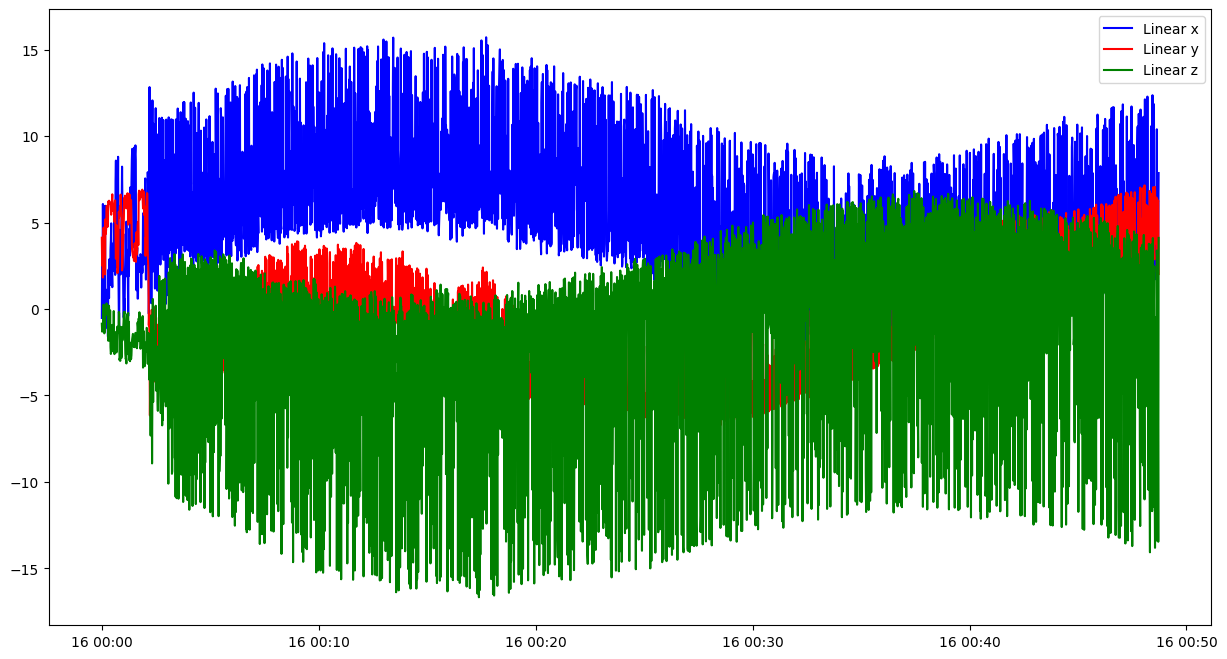

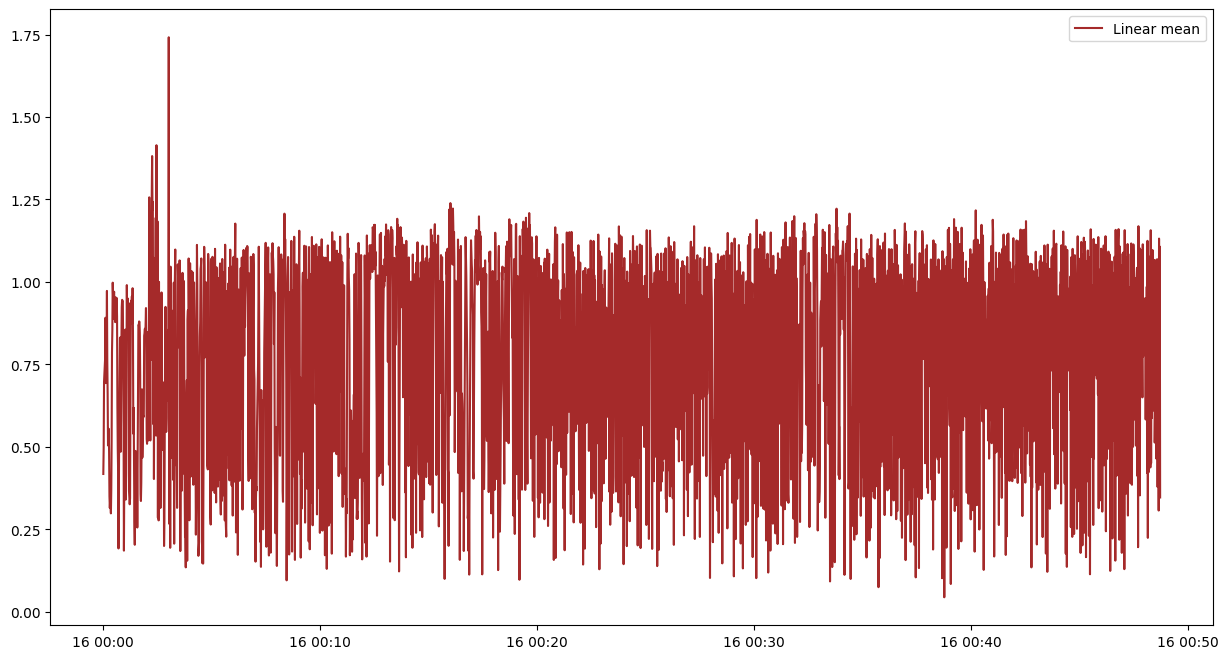

In [13]:
# Plot the data

plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'],df['Linear x'], label='Linear x', color='blue')
plt.plot(df['Timestamp'],df['Linear y'], label='Linear y', color='red')
plt.plot(df['Timestamp'],df['Linear z'], label='Linear z', color='green')
plt.legend()
plt.show()

df['Linear rms'] = np.sqrt(df['Linear x']**2 + df['Linear y']**2 + df['Linear z']**2)
plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'],df['Angular rms'], label='Linear mean', color='brown')
plt.legend()
plt.show()

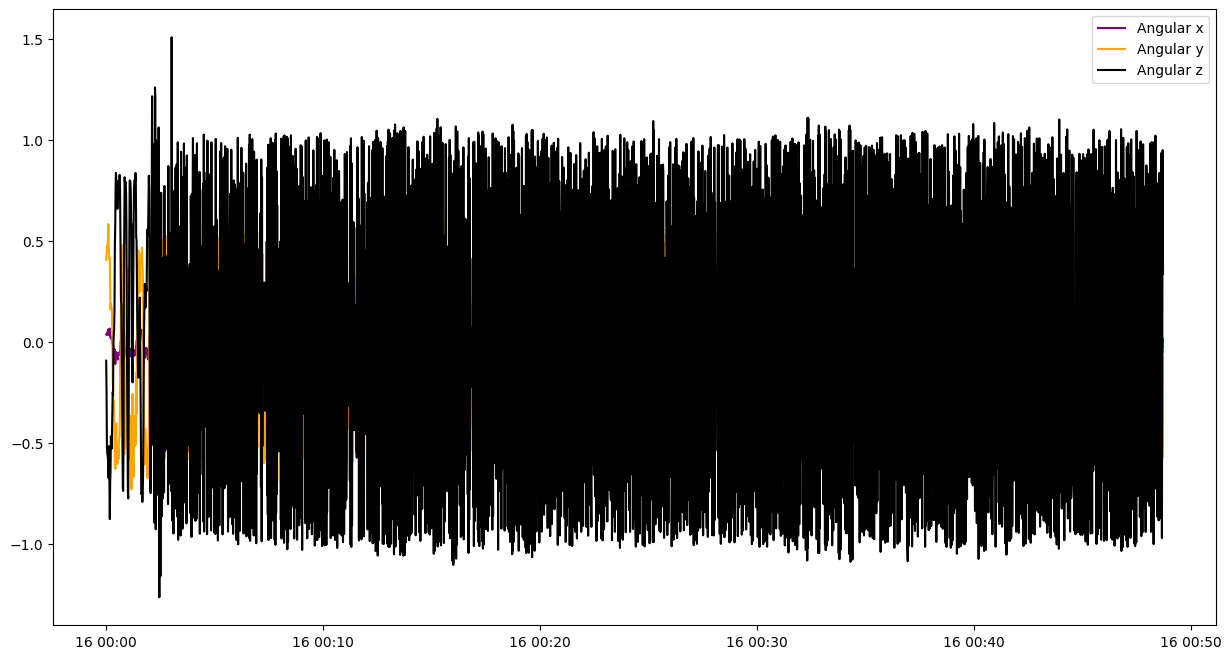

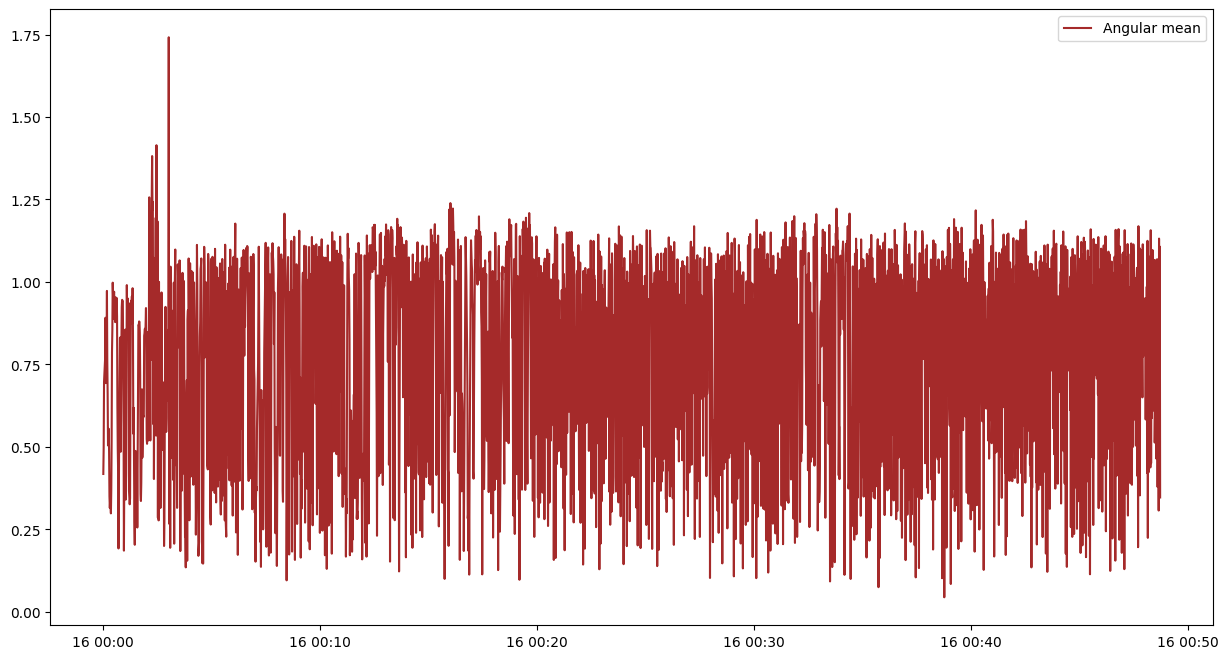

In [14]:
plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'],df['Angular x'], label='Angular x', color='purple')
plt.plot(df['Timestamp'],df['Angular y'], label='Angular y', color='orange')
plt.plot(df['Timestamp'],df['Angular z'], label='Angular z', color='black')
plt.legend()
plt.show()

df['Angular rms'] = np.sqrt(df['Angular x']**2 + df['Angular y']**2 + df['Angular z']**2)
plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'],df['Angular rms'], label='Angular mean', color='brown')
plt.legend()
plt.show()

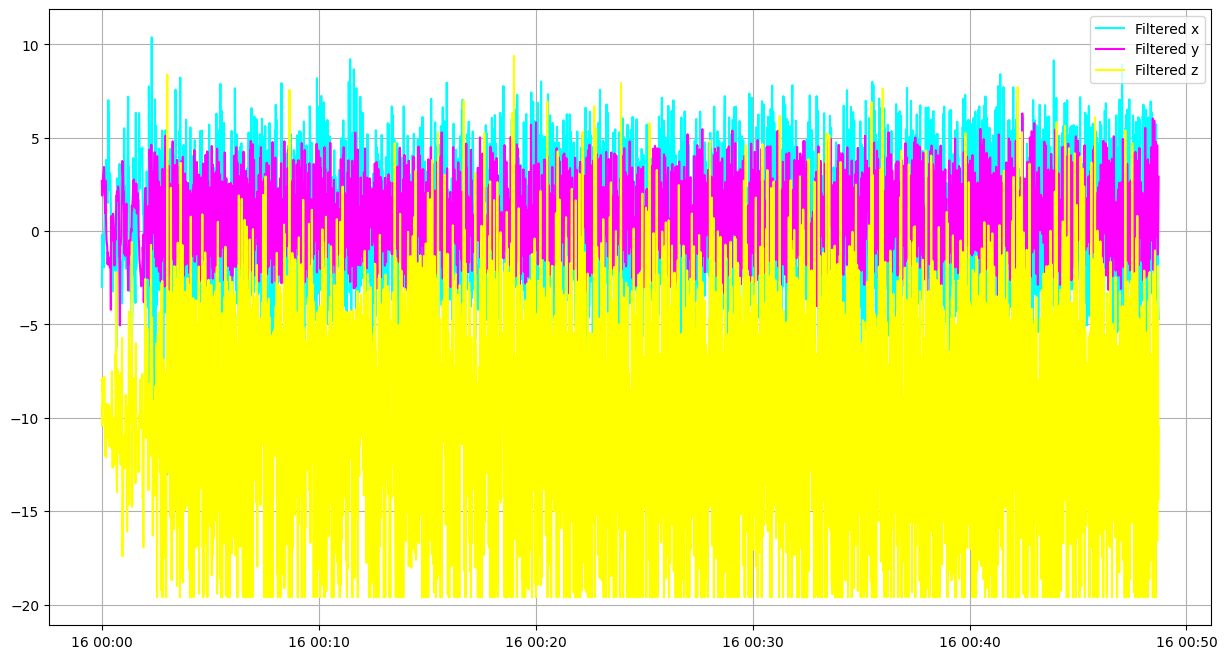

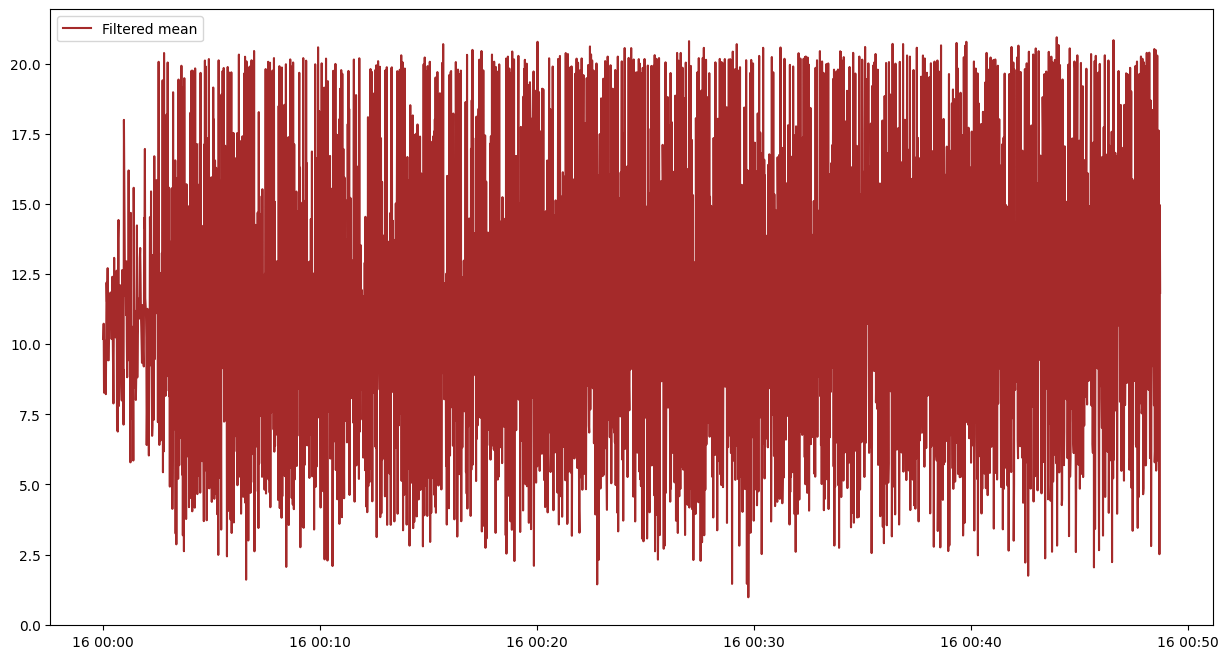

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'],df['Filtered x'], label='Filtered x', color='cyan')
plt.plot(df['Timestamp'],df['Filtered y'], label='Filtered y', color='magenta')
plt.plot(df['Timestamp'],df['Filtered z'], label='Filtered z', color='yellow')
plt.grid()
plt.legend()
plt.show()

df['Filtered rms'] = np.sqrt(df['Filtered x']**2 + df['Filtered y']**2 + df['Filtered z']**2)   
plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'],df['Filtered rms'], label='Filtered mean', color='brown')
plt.legend()
plt.show()

In [16]:
# Function to convert a DataFrame to input sequences and labels for a time series prediction model
def df_to_x_y(df, window_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]] # Create a 2D array of the current window of data
        x.append(row) # Append the 2D array to the input sequences list
        label = df_as_np[i+window_size] # Append the label for the next element to the labels list
        y.append(label)
    return np.array(x), np.array(y)

In [18]:
WINDOW_SIZE = 5
x, y =df_to_x_y(df['Linear x'], WINDOW_SIZE)
x.shape, y.shape

((2822, 5, 1), (2822,))

In [21]:
# Split the data into train, test and validation

X_train, y_train = x[:2000], y[:2000]
X_val, y_val = x[2000:2500], y[2000:2500]
X_test, y_test = x[2500:], y[2500:]

In [25]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, InputLayer, StackedRNNCells, LSTMCell, RNN


# Define LSTM cells
lstm_cell_1 = LSTMCell(units=512)
lstm_cell_2 = LSTMCell(units=256)
lstm_cell_3 = LSTMCell(units=128)


# Stack the LSTM cells
stacked_lstm = StackedRNNCells([lstm_cell_1, lstm_cell_2, lstm_cell_3])

# Create the RNN layer with the stacked LSTM cells
rnn_layer = RNN(stacked_lstm)

# Build the model
model1 = Sequential()
model1.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))  # Define input shape
model1.add(rnn_layer)  # Add the custom stacked RNN layer
model1.add(Dense(64, activation='relu'))  # Fully connected layer
model1.add(Dense(1))  # Output layer

# Print the model summary
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_1 (RNN)                 (None, 128)               2037248   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,045,569
Trainable params: 2,045,569
Non-trainable params: 0
_________________________________________________________________


In [26]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Create a callback to save the best model during training

cp = ModelCheckpoint(filepath='models/best_model.h5', save_best_only=True)
model1.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [27]:
# Train the model
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[cp])

Epoch 1/10
63/63 [==============================] - 8s 77ms/step - loss: 18.2505 - root_mean_squared_error: 4.2721 - val_loss: 14.8903 - val_root_mean_squared_error: 3.8588
Epoch 2/10
63/63 [==============================] - 4s 69ms/step - loss: 13.3791 - root_mean_squared_error: 3.6577 - val_loss: 17.5515 - val_root_mean_squared_error: 4.1895
Epoch 3/10
63/63 [==============================] - 5s 72ms/step - loss: 13.6608 - root_mean_squared_error: 3.6961 - val_loss: 16.0517 - val_root_mean_squared_error: 4.0065
Epoch 4/10
63/63 [==============================] - 5s 79ms/step - loss: 13.2357 - root_mean_squared_error: 3.6381 - val_loss: 14.0863 - val_root_mean_squared_error: 3.7532
Epoch 5/10
63/63 [==============================] - 5s 83ms/step - loss: 13.4361 - root_mean_squared_error: 3.6655 - val_loss: 14.7751 - val_root_mean_squared_error: 3.8438
Epoch 6/10
63/63 [==============================] - 5s 80ms/step - loss: 13.1818 - root_mean_squared_error: 3.6307 - val_loss: 14.1181 

In [28]:
from tensorflow.keras.models import load_model

# Load the best model
model1 = load_model('models/best_model.h5')

In [29]:
# Evaluate the model on the test data

train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions' :train_predictions, 'Actual' :y_train})
train_results

63/63 [==============================] - 1s 17ms/step


,Train Predictions,Actual
0,3.522019,1.22
1,3.748246,2.50
2,2.873118,5.97
3,2.645264,-0.31
4,2.882405,-1.10
...,...,...
1995,1.992558,-0.15
1996,1.513386,-1.32
1997,2.072751,4.53
1998,1.452916,0.42


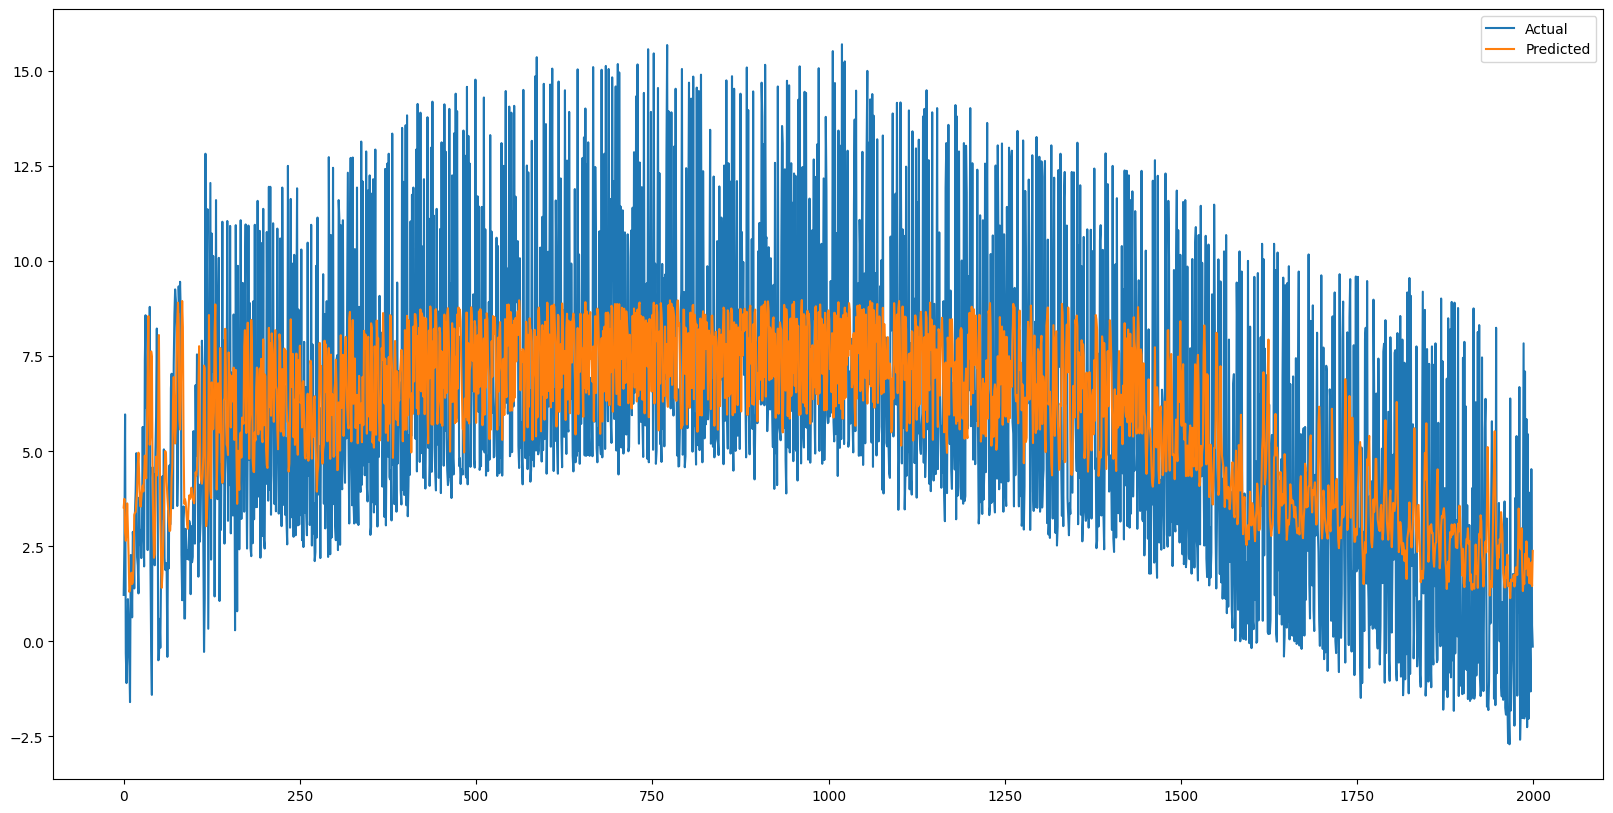

In [31]:
# Plot the predictions and actual values

plt.figure(figsize=(20,10))
plt.plot(train_results['Actual'])
plt.plot(train_results['Train Predictions'])
plt.legend(['Actual', 'Predicted'])
plt.show()


In [32]:
# Generate predictions for the validation set using model1 and flatten the result to a 1D array

val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actual': y_val})
val_results

16/16 [==============================] - 0s 15ms/step


,Val Predictions,Actual
0,1.763209,6.05
1,2.112030,-2.15
2,2.908370,-2.45
3,2.099700,2.89
4,1.653796,-1.30
...,...,...
495,3.548642,2.62
496,3.510254,-0.71
497,3.454081,1.46
498,2.854955,7.75


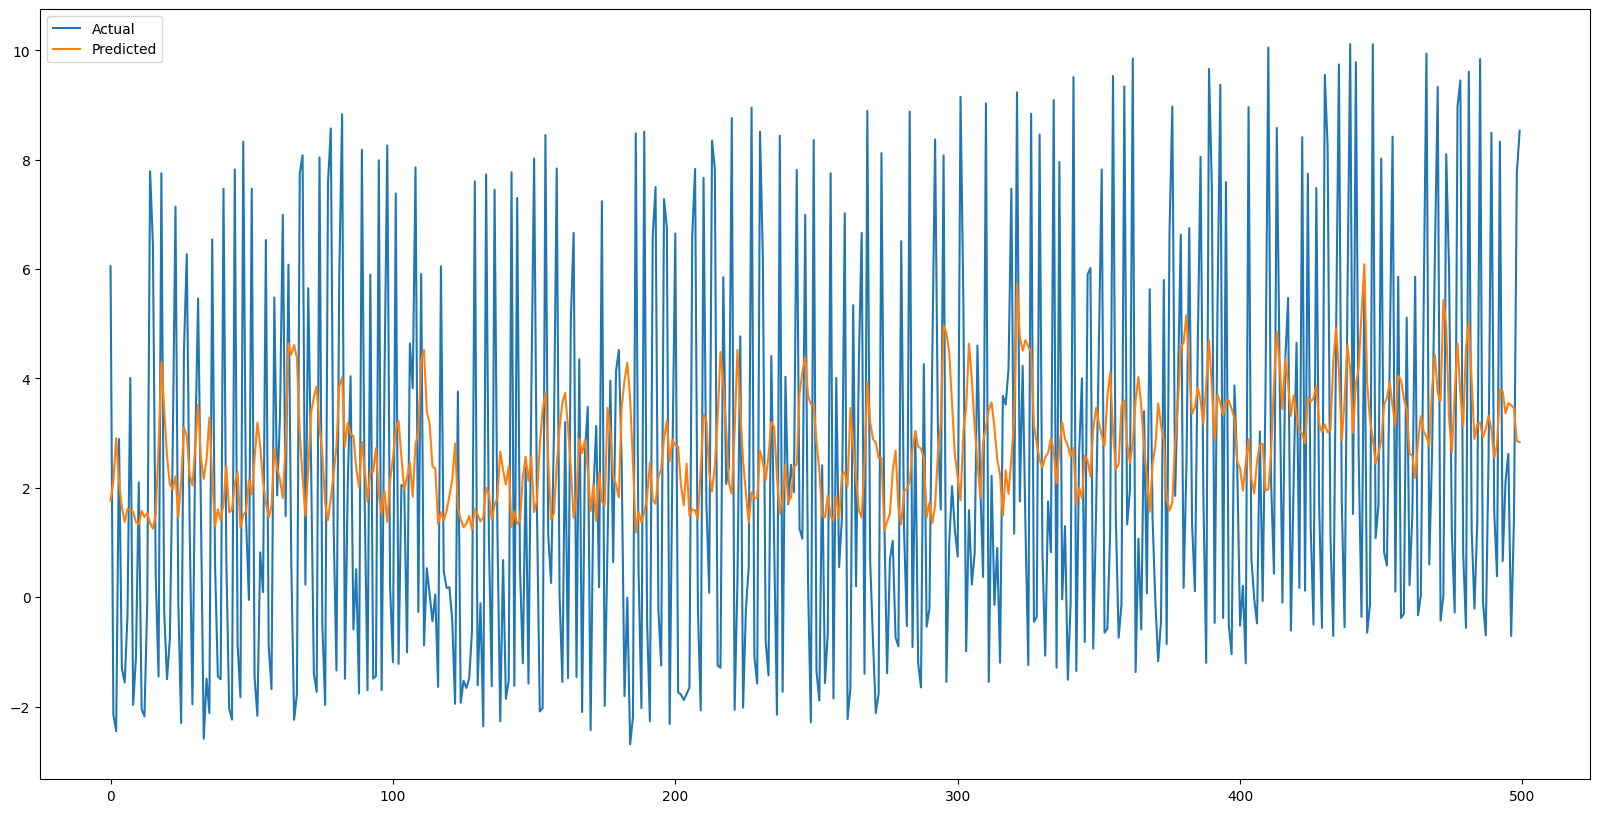

In [39]:
# Plot the predictions and actual values for the validation set

plt.figure(figsize=(20,10))
plt.plot(val_results['Actual'])
plt.plot(val_results['Val Predictions'])
plt.legend(['Actual', 'Predicted'])
plt.show()

In [40]:
# Generate predictions for the test set using model1 and flatten the result to a 1D array

test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions' :test_predictions, 'Actual' :y_test})
test_results

11/11 [==============================] - 0s 20ms/step


,Test Predictions,Actual
0,3.004502,-0.24
1,4.552845,-0.20
2,4.817811,-0.61
3,3.465986,9.85
4,2.470375,10.02
...,...,...
317,3.957355,2.30
318,5.021936,3.72
319,5.589654,2.20
320,5.525071,4.07


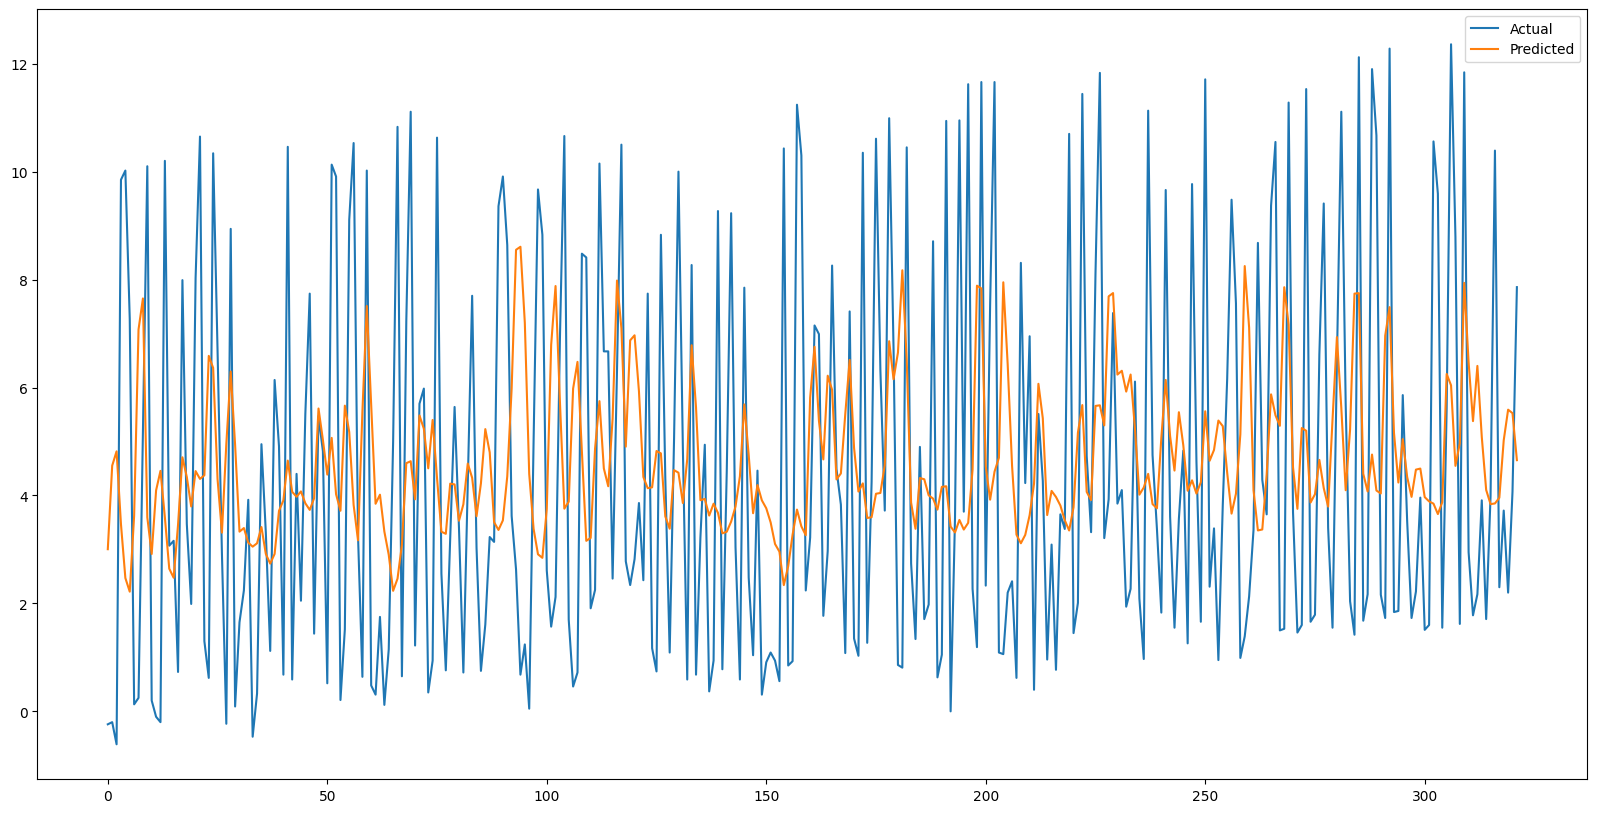

In [41]:
# Plot the predictions and actual values for the test set

plt.figure(figsize=(20,10))
plt.plot(test_results['Actual'])
plt.plot(test_results['Test Predictions'])
plt.legend(['Actual', 'Predicted'])
plt.show()